In [31]:
import cv2
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import os
from deepface import DeepFace as df
#from retinaface import RetinaFace as m
#from PIL import Image
#import imagehash
import pandas as pd
from pymongo import MongoClient
from deepface.commons import functions
from tqdm import tqdm
import mediapipe as mp

576 576


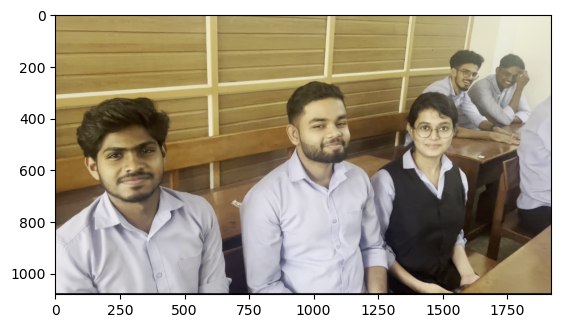

In [32]:
video = cv2.VideoCapture('Data/Video/input2.MOV')
count = 0
frames_arr = []
while video.isOpened():
    ret, frame = video.read()

    if not ret:
        break
    frames_arr.append(frame)                                         # Frames stored in frames_arr
    count += 1
video.release()
print(len(frames_arr), count)


img = frames_arr[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [4]:
%%time
frames = []
frames.append(frames_arr[0])
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for i in range(1, len(frames_arr)):
    keypoints1, descriptors1 = orb.detectAndCompute(frames[-1], None)
    keypoints2, descriptors2 = orb.detectAndCompute(frames_arr[i], None)
    matches = bf.match(descriptors1, descriptors2)
    
    #matches = sorted(matches, key=lambda x: x.distance)
    
    if len(matches) < 200:
        frames.append(frames_arr[i])
print(len(frames))


55
CPU times: total: 30.1 s
Wall time: 29.8 s


In [27]:
%%time
detected_faces = []
img = frames_arr[0]
mp_face_detction = mp.solutions.face_detection
for frame in frames:
    with mp_face_detction.FaceDetection(model_selection = 1, min_detection_confidence = 0.5) as face_detection:
        results = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        for detection in results.detections:
            box = detection.location_data.relative_bounding_box
            x_start, y_start = int(box.xmin * img.shape[1]), int(box.ymin * img.shape[0])
            x_end, y_end = int((box.xmin + box.width) * img.shape[1]), int((box.ymin + box.height) * img.shape[0])

            if x_start < 0 or y_start < 0:
                continue

            face = frame[y_start:y_end, x_start:x_end]
            face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
            detected_faces.append(face)
print(len(detected_faces))

266
CPU times: total: 3.19 s
Wall time: 4.3 s


258


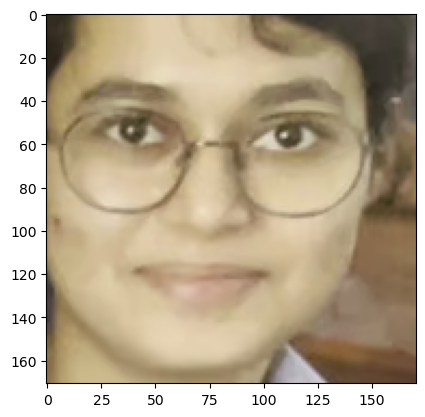

In [28]:
faces = []
faces.append(cv2.convertScaleAbs(detected_faces[0]))
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for i in range(1, len(detected_faces)):
    img2 = cv2.convertScaleAbs(detected_faces[i])

    

    keypoints1, descriptors1 = orb.detectAndCompute(faces[-1], None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    if descriptors2 is None:
        
        continue

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(descriptors1, descriptors2)

    #matches = sorted(matches, key=lambda x: x.distance)

    if len(matches) < 200:
        faces.append(detected_faces[i])

detected_faces[:]=faces[:]
print(len(detected_faces))

plt.imshow(detected_faces[2])

In [ ]:
#connect to database
client=MongoClient('mongodb://localhost:27017')
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)    
    

In [ ]:
db=client['students']

In [ ]:
classes_collection=db['classes']
known_faces_collection=db['known_faces']
attendance_collection=db['attendance']
student_collection=db['stud_details']


In [ ]:
#store pkl file to db
import pickle
from bson.binary import Binary



# Load data from a Pickle file
with open('Data/pkl/representations_facenet.pkl', 'rb') as file:
    data_to_store = pickle.load(file)

# Convert the loaded data to binary using pickle
binary_data = Binary(pickle.dumps(data_to_store))

# Insert the binary data into MongoDB
classes_collection.insert_one({'class':'2k20','pkl': binary_data})





In [ ]:
%%time
#recognize faces and find present students

import tempfile
import pickle
from bson.binary import Binary
import shutil



# Specify the condition for fetching documents
condition = {"class": "2k20"}

# Retrieve the document from MongoDB based on the condition
document = classes_collection.find_one(condition)

if document:
    # Retrieve the binary data from the MongoDB document
    binary_data_from_mongo = document['pkl']

    # Create a temporary folder
    temp_folder = tempfile.mkdtemp()

    # Path to the Pickle file inside the temporary folder
    pickle_file_path = f"{temp_folder}/representations_facenet.pkl"

    # Save the binary data to the temporary folder
    with open(pickle_file_path, 'wb') as file:
        file.write(binary_data_from_mongo)
        

    # Load the Pickle file from mongodb
    with open(pickle_file_path, 'rb') as file:
        loaded_data = pickle.load(file)
    # Perform some processing with the loaded data-face recognition
    models=[]
    res=[]
    present=[]
    for i in range(len(detected_faces)):
        model=df.find(img_path=detected_faces[i],db_path=temp_folder,model_name="Facenet",distance_metric="euclidean",enforce_detection=False,normalization="Facenet",detector_backend='mediapipe')
        models.append(model)
    print()
    count = 0
    for model in models:
        if len(model[0]) > 0:
            name=model[0]['identity'].values[0].split('\\')[-1].split('/')[-1].split('.')[-2]
            print(count , "_ ", name)
            if name not in present:
                present.append(name)
        else:
            print('Unknown Face detected')
        count += 1
    print(present)
    # Clean up: Delete the temporary folder and its contents
    shutil.rmtree(temp_folder)
else:
    print("No document found with class attribute '2k20' in MongoDB.")


In [ ]:
# Function to get absent students
def get_absent_students(present, collection):
    
    
    # Query MongoDB for students not present
    absent_students = collection.find({'name': {'$nin': present}})
    
    # Extract student names from MongoDB cursor
    absent = [student['name'] for student in absent_students]
    
    return absent

# Example usage
if __name__ == "__main__":
    
    collection_name = student_collection # Name of the MongoDB collection
    
    
    absent = get_absent_students(present, collection_name)
    print("Absent Students:", absent)

In [ ]:
#generate csv file#store data in attendance collection
import csv
from datetime import datetime
# Function to generate CSV file from MongoDB
def generate_csv_from_document(document, output_file):
    # Prepare data for CSV file
    csv_data = [['Class', 'Period', 'Date', 'Time', 'Present Students', 'Absent Students'],
                [document['class'], document['period'], document['date'], document['time'], ','.join(document.get('present', [])), ','.join(document.get('absent', []))]]
    
    # Write data to CSV file
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    print("CSV file generated successfully.")



# Get input from user
batch = input('Enter class: ')
period = input('Enter period: ')
date = datetime.now().strftime('%Y-%m-%d')
time = datetime.now().strftime('%H:%M:%S')
present = present  # You need to define the 'present' list here
absent = absent   # You need to define the 'absent' list here

# Insert document into MongoDB collection
inserted_document = {"class": batch, "period": period, "date": date, "time": time, "present": present, "absent": absent}
attendance_collection.insert_one(inserted_document)
# Generate CSV file immediately after inserting the document
generate_csv_from_document(inserted_document, 'Data/attendance.csv')

In [ ]:

# Function to import data from CSV to MongoDB
def import_csv_to_mongodb(csv_file, collection):
    # Read CSV file into a pandas DataFrame
    data = pd.read_csv(csv_file)
    

    
    
    # Convert DataFrame to dictionary
    data_dict = data.to_dict(orient='records')
    
    # Insert data into MongoDB collection
    collection.insert_many(data_dict)
    
   
    
    print("Data imported successfully into MongoDB.")

# Example usage
if __name__ == "__main__":
    csv_file = 'Data/names.csv'  # Path to your CSV file
    collection_name = student_collection  # Name of the MongoDB collection
    
    
    import_csv_to_mongodb(csv_file, collection_name)

In [ ]:
# %%time
# detected=[]
# detected_faces=[]
# for frame in frames[:10]:
#     detected.append(df.extract_faces(frame))
# for i in range(len(detected)):
#     detected_faces.append(detected[i][1]['face'])



CPU times: total: 0 ns
Wall time: 26 ms


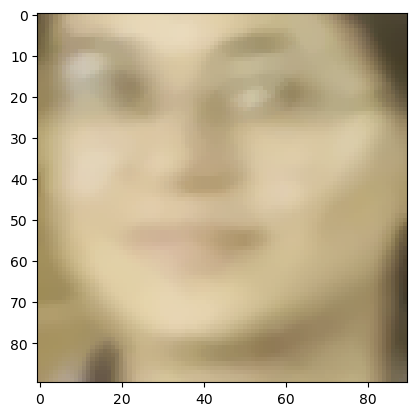

In [67]:
%%time
#image denoising using opencv

import numpy as np

def deblur_image(image):
    # Perform deblurring using your preferred method
    # This could be a function like the one provided earlier
    # For simplicity, I'll assume a placeholder deblurring function here
    deblurred_image = cv2.medianBlur(image, 5)  # Placeholder deblurring function
    return deblurred_image
 
deblurred_face = deblur_image(detected_faces[100])
plt.imshow(deblurred_face)

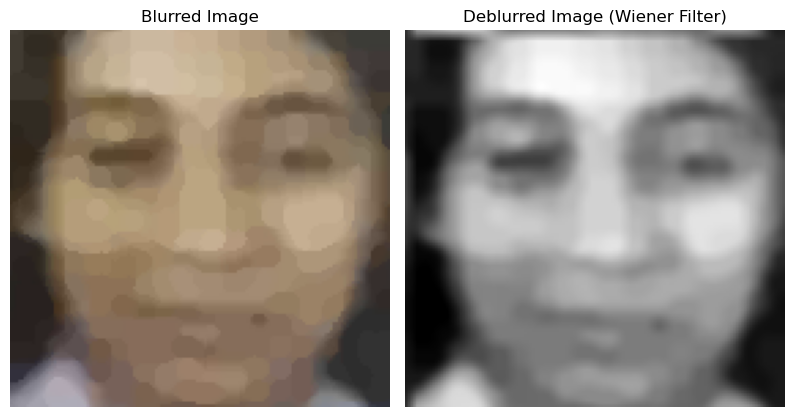

In [54]:
#wiener
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import color, data
from scipy.ndimage import gaussian_filter
from skimage import img_as_float

def wiener_filter_deblur(blurred_image, psf, regularization):
    # Convert the image to grayscale if it's in color
    if blurred_image.ndim == 3:
        blurred_image = color.rgb2gray(blurred_image)

    # Convert the PSF and the blurred image to float
    psf = psf.astype(float)
    blurred_image = blurred_image.astype(float)

    # Resize the PSF to match the size of the blurred image
    psf_resized = np.zeros_like(blurred_image)
    psf_resized[:psf.shape[0], :psf.shape[1]] = psf

    # Apply the Wiener filter to deblur the image
    wiener_filter = np.conj(psf_resized) / (np.abs(psf_resized) ** 2 + regularization)
    deblurred_image = np.real(np.fft.ifft2(np.fft.fft2(blurred_image) * np.fft.fft2(wiener_filter)))

    return deblurred_image

# Load your own blurred image
#blurred_image = plt.imread('Data/WIN_20240217_22_04_07_Pro.jpg')
blurred_image = deblurred_face

# Define the PSF (Point Spread Function)
psf = np.ones((5, 5)) / 25  # Example PSF, you should replace it with your actual PSF

# Set the regularization parameter for the Wiener filter
regularization_param = 0.1  # Adjust this parameter based on your image characteristics

# Deblur the image using the Wiener filter
deblurred_image = wiener_filter_deblur(blurred_image, psf, regularization_param)

# Normalize the deblurred image to range [0, 1]
deblurred_image_normalized = (deblurred_image - np.min(deblurred_image)) / (np.max(deblurred_image) - np.min(deblurred_image))

deblurred_image_uint8 = (deblurred_image_normalized * 255).astype(np.uint8)
# Convert the deblurred image to RGB
deblurred_image_rgb = color.gray2rgb(deblurred_image_uint8)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(deblurred_image_rgb)
plt.title('Deblurred Image (Wiener Filter)')
plt.axis('off')

plt.tight_layout()
plt.show()


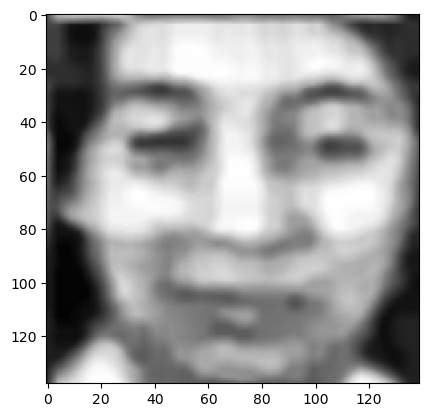

In [55]:
#contrast enhancement
import cv2
import numpy as np

img = deblurred_image_rgb
# converting to LAB color space
lab= cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
l_channel, a, b = cv2.split(lab)

# Applying CLAHE to L-channel
# feel free to try different values for the limit and grid size:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(l_channel)

# merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))

# Converting image from LAB Color model to BGR color spcae
enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
plt.imshow(enhanced_img)

In [57]:
model=df.find(img_path=deblurred_image_rgb,db_path='Data/known_faces',model_name="Facenet",distance_metric="euclidean",enforce_detection=False,normalization="Facenet",detector_backend='mediapipe')
model[0]

There are  54  representations found in  representations_facenet.pkl
find function lasts  0.17665982246398926  seconds


,identity,source_x,source_y,source_w,source_h,Facenet_euclidean


In [68]:
models=[]
res=[]
present=[]
for i in range(len(detected_faces)):
    model=df.find(img_path=detected_faces[i],db_path='Data/known_faces',model_name="Facenet",distance_metric="euclidean",enforce_detection=False,normalization="Facenet",detector_backend='mediapipe')
    models.append(model)
print()
count = 0
for model in models:
    if len(model[0]) > 0:
        name=model[0]['identity'].values[0].split('\\')[-1].split('/')[-1].split('.')[-2]
        print(count , "_ ", name)
        if name not in present:
            present.append(name)
    else:
        print('Unknown Face detected')
    count += 1

There are  54  representations found in  representations_facenet.pkl
find function lasts  3.3148794174194336  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.22648882865905762  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.17904448509216309  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.16827678680419922  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15900588035583496  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1666278839111328  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1561572551727295  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.2627840042114258  seconds
There are  54  representations found in  representat

find function lasts  0.16737604141235352  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1513073444366455  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.246504545211792  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.20375514030456543  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15480875968933105  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14229369163513184  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.16632747650146484  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1344895362854004  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15602350234985352  seconds
Th

find function lasts  0.1504683494567871  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.2712595462799072  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.2495560646057129  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13939118385314941  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15032219886779785  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.20240306854248047  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.19941115379333496  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1812913417816162  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14493608474731445  seconds
Th

find function lasts  0.2504570484161377  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.210052490234375  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14814281463623047  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15986013412475586  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15284132957458496  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14610052108764648  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1448349952697754  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1423344612121582  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15497660636901855  seconds
The

find function lasts  0.15732121467590332  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14491605758666992  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.19278669357299805  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1306166648864746  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1351785659790039  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13202428817749023  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13393092155456543  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.20329546928405762  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14426517486572266  seconds


find function lasts  0.13620328903198242  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.16864013671875  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.19273686408996582  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.17836570739746094  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13725876808166504  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1325373649597168  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15613985061645508  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1343226432800293  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15866422653198242  seconds
The

find function lasts  0.1439659595489502  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.17746353149414062  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1658017635345459  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15121722221374512  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14037632942199707  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1349039077758789  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.18986725807189941  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.16223549842834473  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1708521842956543  seconds
Th

find function lasts  0.22408485412597656  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14330482482910156  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.156569242477417  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.21502065658569336  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.34130048751831055  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.2953801155090332  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.16420269012451172  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.17088890075683594  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.2709333896636963  seconds
Th

find function lasts  0.13623571395874023  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13352632522583008  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13245677947998047  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13350510597229004  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.18652820587158203  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1313037872314453  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13358020782470703  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.2469158172607422  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.17205452919006348  seconds


find function lasts  0.1352391242980957  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1317753791809082  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13596296310424805  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13412237167358398  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1479320526123047  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13431668281555176  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14031696319580078  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13509082794189453  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.29906702041625977  seconds
T

find function lasts  0.1811056137084961  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13177776336669922  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13960003852844238  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13556718826293945  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.2491457462310791  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1919996738433838  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15420150756835938  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13407182693481445  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13745784759521484  seconds
T

In [69]:
print(present)

['Devanarayan_S_R', 'Amal_G', 'Ardra', 'Devanarayan_S_R1', 'Yadu_Krishna', 'Anusree', 'Ameeza2', 'A_Nafih', 'Ameeza', 'Arjun_P_J', 'Tona_Antony', 'Krishnendu', 'Aswanth_K1', 'Anagha_A_S', 'Ardra1', 'Ashni_Chinnu1', 'Athira', 'Akshay_P', 'Neha_P', 'Thejus_M', 'Athul_Benny', 'Vyshna_S', 'Ajmila_Shada', 'Arjun_PJ1', 'Fathih_A_F', 'Vyshnav_K1']


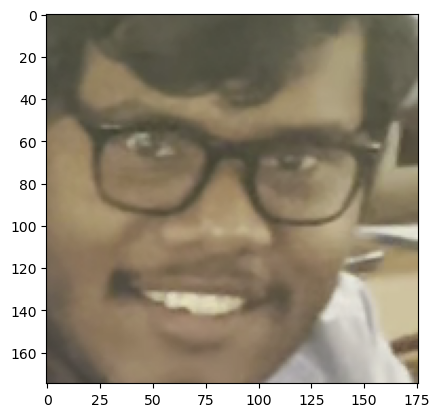

In [79]:
plt.imshow(detected_faces[257])